# Satifsying requirements

In [1]:
import json
import torch
import pennylane as qml
import numpy as np

%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


# Downloading data

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

C:\Users\OLEG\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Preparing data with DataLoaders

In [4]:
from torch.utils.data import DataLoader

loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=80, 
                                          shuffle=True, 
                                          num_workers=1,
                                          pin_memory=True),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1,
                                          pin_memory=True),
}

# Defining a NN

In [5]:
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(features=inputs, wires=range(n_qubits))
    
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    
    return [qml.expval(qml.PauliY(wires=i)) for i in range(n_qubits)]

In [6]:
n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

In [7]:
import torch.nn as nn

class HybridNN(nn.Module):
    def __init__(self):
        super(HybridNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,              
                stride=1,                   
                padding=2,    
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),                
        )
        self.fc_1 = nn.Sequential(
            nn.Linear(32 * 7 * 7, 20),
            nn.BatchNorm1d(20),
            nn.ReLU(),
        )
        
        # LIST USAGE?
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_2 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_3 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_4 = qml.qnn.TorchLayer(qnode, weight_shapes)
        
        self.qlayer_1.to(device)
        self.qlayer_2.to(device)
        self.qlayer_3.to(device)
        self.qlayer_4.to(device)
        
        self.after_q = nn.Sequential(
            nn.BatchNorm1d(20),
            nn.ReLU(),
        )
        
        self.fc_2 = nn.Linear(20, 10)

        
    def forward(self, x):

        x = self.conv1(x)

        x = self.conv2(x)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1) 

        x = self.fc_1(x)
        #print('Before split')
        x_1, x_2, x_3, x_4 = torch.split(x, 5, dim=1) # second argument is number of elements in one new tensor
        #print('After split')
        #x = torch.Tensor(0)
        
        x_1 = self.qlayer_1(x_1)
        x_2 = self.qlayer_2(x_2)
        x_3 = self.qlayer_3(x_3)
        x_4 = self.qlayer_4(x_4)
        
        #print(x.device)
        
        x = torch.cat([x_1, x_2, x_3, x_4], axis=1)
        x = x.to(device)
        x = self.after_q(x)
        logits = self.fc_2(x)
        
        return logits

In [8]:
hnn = HybridNN()
hnn = hnn.to(device)
print(hnn)

HybridNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_1): Sequential(
    (0): Linear(in_features=1568, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (qlayer_1): <Quantum Torch Layer: func=qnode>
  (qlayer_2): <Quantum Torch Layer: func=qnode>
  (qlayer_3): <Quantum Torch Layer: func=qnode>
  (qlayer_4): <Quantum Torch Layer: func=qnode>
  (after_q): Sequential(

# Training

In [9]:
loss_func = nn.CrossEntropyLoss()

In [10]:
from torch import optim

optimizer = optim.AdamW(hnn.parameters(), lr = 0.01)  

In [11]:
from tqdm.notebook import trange
from torch.autograd import Variable

def train(num_epochs, model, loaders):
    
    model.train()
    history = []
    
    avg_loss = 0.0
    val_loss = 0.0
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in trange(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            b_x, b_y = images.to(device), labels.to(device)
            
            optimizer.zero_grad()           
            
            output = model(b_x)             
            loss = loss_func(output, b_y)
            
            loss.backward()               
            optimizer.step()
            avg_loss += loss.item() / len(loaders['train'])
            
            if (i+1) % 10 >= 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        
        model.eval()        
        for X_batch, Y_batch in loaders['test']:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            with torch.set_grad_enabled(False):
                outputs = model(X_batch)
                loss = loss_func(outputs, Y_batch)
                val_loss += loss.item() / len(loaders['test'])
            
        history.append((avg_loss, val_loss))
        print('Epoch [{}/{}], Tr. loss: {:.4f}. Test loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, avg_loss, val_loss))
        print('\n')
        torch.save(hnn.state_dict(), 'trained_model_24qubits_3_layers_with_strong_entagling_' + str(i+1) + 'ep5qu.pt')
        with open('data_' + str(i+1) + 'ep5qu.txt', 'w') as outfile:
            json.dump(history, outfile)
    return history

In [12]:
num_epochs = 8

history = train(num_epochs, hnn, loaders)

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\OLEG\anaconda3\lib\site-packages\torch\autograd\__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ..\aten\src\ATen\native\Copy.cpp:240.)
  Variable._execution_engine.run_backward(


Epoch [1/8], Step [1/750], Loss: 2.4006
Epoch [1/8], Step [2/750], Loss: 2.2367
Epoch [1/8], Step [3/750], Loss: 2.1521
Epoch [1/8], Step [4/750], Loss: 1.9708
Epoch [1/8], Step [5/750], Loss: 1.9448
Epoch [1/8], Step [6/750], Loss: 1.9341
Epoch [1/8], Step [7/750], Loss: 1.8421
Epoch [1/8], Step [8/750], Loss: 1.7785
Epoch [1/8], Step [9/750], Loss: 1.7914
Epoch [1/8], Step [10/750], Loss: 1.6977
Epoch [1/8], Step [11/750], Loss: 1.5762
Epoch [1/8], Step [12/750], Loss: 1.6286
Epoch [1/8], Step [13/750], Loss: 1.4751
Epoch [1/8], Step [14/750], Loss: 1.3993
Epoch [1/8], Step [15/750], Loss: 1.5742
Epoch [1/8], Step [16/750], Loss: 1.4418
Epoch [1/8], Step [17/750], Loss: 1.1578
Epoch [1/8], Step [18/750], Loss: 1.3520
Epoch [1/8], Step [19/750], Loss: 1.1554
Epoch [1/8], Step [20/750], Loss: 1.0575
Epoch [1/8], Step [21/750], Loss: 1.0462
Epoch [1/8], Step [22/750], Loss: 1.1375
Epoch [1/8], Step [23/750], Loss: 0.9748
Epoch [1/8], Step [24/750], Loss: 0.9348
Epoch [1/8], Step [25/750

Epoch [1/8], Step [199/750], Loss: 0.1943
Epoch [1/8], Step [200/750], Loss: 0.0629
Epoch [1/8], Step [201/750], Loss: 0.0743
Epoch [1/8], Step [202/750], Loss: 0.2051
Epoch [1/8], Step [203/750], Loss: 0.1137
Epoch [1/8], Step [204/750], Loss: 0.0783
Epoch [1/8], Step [205/750], Loss: 0.1751
Epoch [1/8], Step [206/750], Loss: 0.1624
Epoch [1/8], Step [207/750], Loss: 0.1419
Epoch [1/8], Step [208/750], Loss: 0.0509
Epoch [1/8], Step [209/750], Loss: 0.0444
Epoch [1/8], Step [210/750], Loss: 0.0818
Epoch [1/8], Step [211/750], Loss: 0.0878
Epoch [1/8], Step [212/750], Loss: 0.1790
Epoch [1/8], Step [213/750], Loss: 0.1059
Epoch [1/8], Step [214/750], Loss: 0.1426
Epoch [1/8], Step [215/750], Loss: 0.0893
Epoch [1/8], Step [216/750], Loss: 0.1344
Epoch [1/8], Step [217/750], Loss: 0.0944
Epoch [1/8], Step [218/750], Loss: 0.0617
Epoch [1/8], Step [219/750], Loss: 0.1382
Epoch [1/8], Step [220/750], Loss: 0.1395
Epoch [1/8], Step [221/750], Loss: 0.0370
Epoch [1/8], Step [222/750], Loss:

Epoch [1/8], Step [395/750], Loss: 0.0233
Epoch [1/8], Step [396/750], Loss: 0.0117
Epoch [1/8], Step [397/750], Loss: 0.0687
Epoch [1/8], Step [398/750], Loss: 0.2083
Epoch [1/8], Step [399/750], Loss: 0.0267
Epoch [1/8], Step [400/750], Loss: 0.0419
Epoch [1/8], Step [401/750], Loss: 0.1274
Epoch [1/8], Step [402/750], Loss: 0.1187
Epoch [1/8], Step [403/750], Loss: 0.1631
Epoch [1/8], Step [404/750], Loss: 0.0749
Epoch [1/8], Step [405/750], Loss: 0.1018
Epoch [1/8], Step [406/750], Loss: 0.1024
Epoch [1/8], Step [407/750], Loss: 0.0324
Epoch [1/8], Step [408/750], Loss: 0.1282
Epoch [1/8], Step [409/750], Loss: 0.0486
Epoch [1/8], Step [410/750], Loss: 0.0444
Epoch [1/8], Step [411/750], Loss: 0.1196
Epoch [1/8], Step [412/750], Loss: 0.1716
Epoch [1/8], Step [413/750], Loss: 0.1099
Epoch [1/8], Step [414/750], Loss: 0.0602
Epoch [1/8], Step [415/750], Loss: 0.1207
Epoch [1/8], Step [416/750], Loss: 0.0975
Epoch [1/8], Step [417/750], Loss: 0.0424
Epoch [1/8], Step [418/750], Loss:

Epoch [1/8], Step [591/750], Loss: 0.1133
Epoch [1/8], Step [592/750], Loss: 0.0812
Epoch [1/8], Step [593/750], Loss: 0.0749
Epoch [1/8], Step [594/750], Loss: 0.1037
Epoch [1/8], Step [595/750], Loss: 0.0126
Epoch [1/8], Step [596/750], Loss: 0.1119
Epoch [1/8], Step [597/750], Loss: 0.0940
Epoch [1/8], Step [598/750], Loss: 0.0805
Epoch [1/8], Step [599/750], Loss: 0.0332
Epoch [1/8], Step [600/750], Loss: 0.0416
Epoch [1/8], Step [601/750], Loss: 0.0445
Epoch [1/8], Step [602/750], Loss: 0.0144
Epoch [1/8], Step [603/750], Loss: 0.0225
Epoch [1/8], Step [604/750], Loss: 0.0592
Epoch [1/8], Step [605/750], Loss: 0.0903
Epoch [1/8], Step [606/750], Loss: 0.1255
Epoch [1/8], Step [607/750], Loss: 0.0786
Epoch [1/8], Step [608/750], Loss: 0.0385
Epoch [1/8], Step [609/750], Loss: 0.0694
Epoch [1/8], Step [610/750], Loss: 0.2410
Epoch [1/8], Step [611/750], Loss: 0.0693
Epoch [1/8], Step [612/750], Loss: 0.0782
Epoch [1/8], Step [613/750], Loss: 0.0168
Epoch [1/8], Step [614/750], Loss:

Epoch [2/8], Step [36/750], Loss: 0.1470
Epoch [2/8], Step [37/750], Loss: 0.0684
Epoch [2/8], Step [38/750], Loss: 0.0539
Epoch [2/8], Step [39/750], Loss: 0.1471
Epoch [2/8], Step [40/750], Loss: 0.0276
Epoch [2/8], Step [41/750], Loss: 0.0581
Epoch [2/8], Step [42/750], Loss: 0.1342
Epoch [2/8], Step [43/750], Loss: 0.0804
Epoch [2/8], Step [44/750], Loss: 0.0580
Epoch [2/8], Step [45/750], Loss: 0.1992
Epoch [2/8], Step [46/750], Loss: 0.1404
Epoch [2/8], Step [47/750], Loss: 0.0693
Epoch [2/8], Step [48/750], Loss: 0.1505
Epoch [2/8], Step [49/750], Loss: 0.0313
Epoch [2/8], Step [50/750], Loss: 0.0447
Epoch [2/8], Step [51/750], Loss: 0.0834
Epoch [2/8], Step [52/750], Loss: 0.0608
Epoch [2/8], Step [53/750], Loss: 0.1206
Epoch [2/8], Step [54/750], Loss: 0.0168
Epoch [2/8], Step [55/750], Loss: 0.1483
Epoch [2/8], Step [56/750], Loss: 0.0964
Epoch [2/8], Step [57/750], Loss: 0.0704
Epoch [2/8], Step [58/750], Loss: 0.0089
Epoch [2/8], Step [59/750], Loss: 0.0358
Epoch [2/8], Ste

Epoch [2/8], Step [233/750], Loss: 0.0417
Epoch [2/8], Step [234/750], Loss: 0.0089
Epoch [2/8], Step [235/750], Loss: 0.0930
Epoch [2/8], Step [236/750], Loss: 0.0242
Epoch [2/8], Step [237/750], Loss: 0.0251
Epoch [2/8], Step [238/750], Loss: 0.1216
Epoch [2/8], Step [239/750], Loss: 0.0156
Epoch [2/8], Step [240/750], Loss: 0.0041
Epoch [2/8], Step [241/750], Loss: 0.0065
Epoch [2/8], Step [242/750], Loss: 0.0331
Epoch [2/8], Step [243/750], Loss: 0.1642
Epoch [2/8], Step [244/750], Loss: 0.0748
Epoch [2/8], Step [245/750], Loss: 0.1145
Epoch [2/8], Step [246/750], Loss: 0.0209
Epoch [2/8], Step [247/750], Loss: 0.0493
Epoch [2/8], Step [248/750], Loss: 0.2000
Epoch [2/8], Step [249/750], Loss: 0.1008
Epoch [2/8], Step [250/750], Loss: 0.0989
Epoch [2/8], Step [251/750], Loss: 0.1252
Epoch [2/8], Step [252/750], Loss: 0.0962
Epoch [2/8], Step [253/750], Loss: 0.0561
Epoch [2/8], Step [254/750], Loss: 0.0536
Epoch [2/8], Step [255/750], Loss: 0.0734
Epoch [2/8], Step [256/750], Loss:

Epoch [2/8], Step [429/750], Loss: 0.0136
Epoch [2/8], Step [430/750], Loss: 0.0913
Epoch [2/8], Step [431/750], Loss: 0.1025
Epoch [2/8], Step [432/750], Loss: 0.0150
Epoch [2/8], Step [433/750], Loss: 0.0161
Epoch [2/8], Step [434/750], Loss: 0.2155
Epoch [2/8], Step [435/750], Loss: 0.1092
Epoch [2/8], Step [436/750], Loss: 0.0201
Epoch [2/8], Step [437/750], Loss: 0.0078
Epoch [2/8], Step [438/750], Loss: 0.0817
Epoch [2/8], Step [439/750], Loss: 0.0783
Epoch [2/8], Step [440/750], Loss: 0.0323
Epoch [2/8], Step [441/750], Loss: 0.1991
Epoch [2/8], Step [442/750], Loss: 0.0332
Epoch [2/8], Step [443/750], Loss: 0.0557
Epoch [2/8], Step [444/750], Loss: 0.0109
Epoch [2/8], Step [445/750], Loss: 0.0869
Epoch [2/8], Step [446/750], Loss: 0.0722
Epoch [2/8], Step [447/750], Loss: 0.0955
Epoch [2/8], Step [448/750], Loss: 0.0209
Epoch [2/8], Step [449/750], Loss: 0.0247
Epoch [2/8], Step [450/750], Loss: 0.0079
Epoch [2/8], Step [451/750], Loss: 0.1019
Epoch [2/8], Step [452/750], Loss:

Epoch [2/8], Step [625/750], Loss: 0.0712
Epoch [2/8], Step [626/750], Loss: 0.0288
Epoch [2/8], Step [627/750], Loss: 0.0880
Epoch [2/8], Step [628/750], Loss: 0.0519
Epoch [2/8], Step [629/750], Loss: 0.0221
Epoch [2/8], Step [630/750], Loss: 0.0432
Epoch [2/8], Step [631/750], Loss: 0.0416
Epoch [2/8], Step [632/750], Loss: 0.1085
Epoch [2/8], Step [633/750], Loss: 0.0124
Epoch [2/8], Step [634/750], Loss: 0.0076
Epoch [2/8], Step [635/750], Loss: 0.0707
Epoch [2/8], Step [636/750], Loss: 0.0168
Epoch [2/8], Step [637/750], Loss: 0.0423
Epoch [2/8], Step [638/750], Loss: 0.0290
Epoch [2/8], Step [639/750], Loss: 0.0221
Epoch [2/8], Step [640/750], Loss: 0.0750
Epoch [2/8], Step [641/750], Loss: 0.0495
Epoch [2/8], Step [642/750], Loss: 0.0223
Epoch [2/8], Step [643/750], Loss: 0.0139
Epoch [2/8], Step [644/750], Loss: 0.0715
Epoch [2/8], Step [645/750], Loss: 0.0407
Epoch [2/8], Step [646/750], Loss: 0.0935
Epoch [2/8], Step [647/750], Loss: 0.0733
Epoch [2/8], Step [648/750], Loss:

Epoch [3/8], Step [71/750], Loss: 0.0081
Epoch [3/8], Step [72/750], Loss: 0.0911
Epoch [3/8], Step [73/750], Loss: 0.0369
Epoch [3/8], Step [74/750], Loss: 0.0485
Epoch [3/8], Step [75/750], Loss: 0.0077
Epoch [3/8], Step [76/750], Loss: 0.0119
Epoch [3/8], Step [77/750], Loss: 0.0036
Epoch [3/8], Step [78/750], Loss: 0.0937
Epoch [3/8], Step [79/750], Loss: 0.0682
Epoch [3/8], Step [80/750], Loss: 0.0865
Epoch [3/8], Step [81/750], Loss: 0.1166
Epoch [3/8], Step [82/750], Loss: 0.0299
Epoch [3/8], Step [83/750], Loss: 0.0691
Epoch [3/8], Step [84/750], Loss: 0.0342
Epoch [3/8], Step [85/750], Loss: 0.0367
Epoch [3/8], Step [86/750], Loss: 0.0181
Epoch [3/8], Step [87/750], Loss: 0.0053
Epoch [3/8], Step [88/750], Loss: 0.0291
Epoch [3/8], Step [89/750], Loss: 0.0018
Epoch [3/8], Step [90/750], Loss: 0.0309
Epoch [3/8], Step [91/750], Loss: 0.0780
Epoch [3/8], Step [92/750], Loss: 0.1346
Epoch [3/8], Step [93/750], Loss: 0.0219
Epoch [3/8], Step [94/750], Loss: 0.0102
Epoch [3/8], Ste

Epoch [3/8], Step [267/750], Loss: 0.0058
Epoch [3/8], Step [268/750], Loss: 0.0055
Epoch [3/8], Step [269/750], Loss: 0.0682
Epoch [3/8], Step [270/750], Loss: 0.0380
Epoch [3/8], Step [271/750], Loss: 0.0475
Epoch [3/8], Step [272/750], Loss: 0.0067
Epoch [3/8], Step [273/750], Loss: 0.0426
Epoch [3/8], Step [274/750], Loss: 0.0242
Epoch [3/8], Step [275/750], Loss: 0.0551
Epoch [3/8], Step [276/750], Loss: 0.0083
Epoch [3/8], Step [277/750], Loss: 0.0232
Epoch [3/8], Step [278/750], Loss: 0.0044
Epoch [3/8], Step [279/750], Loss: 0.0663
Epoch [3/8], Step [280/750], Loss: 0.0096
Epoch [3/8], Step [281/750], Loss: 0.0123
Epoch [3/8], Step [282/750], Loss: 0.0317
Epoch [3/8], Step [283/750], Loss: 0.0962
Epoch [3/8], Step [284/750], Loss: 0.0282
Epoch [3/8], Step [285/750], Loss: 0.0053
Epoch [3/8], Step [286/750], Loss: 0.0115
Epoch [3/8], Step [287/750], Loss: 0.0500
Epoch [3/8], Step [288/750], Loss: 0.0492
Epoch [3/8], Step [289/750], Loss: 0.0493
Epoch [3/8], Step [290/750], Loss:

Epoch [3/8], Step [463/750], Loss: 0.0051
Epoch [3/8], Step [464/750], Loss: 0.1053
Epoch [3/8], Step [465/750], Loss: 0.0346
Epoch [3/8], Step [466/750], Loss: 0.1165
Epoch [3/8], Step [467/750], Loss: 0.0156
Epoch [3/8], Step [468/750], Loss: 0.0045
Epoch [3/8], Step [469/750], Loss: 0.0976
Epoch [3/8], Step [470/750], Loss: 0.0352
Epoch [3/8], Step [471/750], Loss: 0.0521
Epoch [3/8], Step [472/750], Loss: 0.0392
Epoch [3/8], Step [473/750], Loss: 0.0014
Epoch [3/8], Step [474/750], Loss: 0.0777
Epoch [3/8], Step [475/750], Loss: 0.0162
Epoch [3/8], Step [476/750], Loss: 0.0189
Epoch [3/8], Step [477/750], Loss: 0.0461
Epoch [3/8], Step [478/750], Loss: 0.0581
Epoch [3/8], Step [479/750], Loss: 0.0456
Epoch [3/8], Step [480/750], Loss: 0.0041
Epoch [3/8], Step [481/750], Loss: 0.0208
Epoch [3/8], Step [482/750], Loss: 0.0046
Epoch [3/8], Step [483/750], Loss: 0.0675
Epoch [3/8], Step [484/750], Loss: 0.0085
Epoch [3/8], Step [485/750], Loss: 0.0741
Epoch [3/8], Step [486/750], Loss:

Epoch [3/8], Step [659/750], Loss: 0.0761
Epoch [3/8], Step [660/750], Loss: 0.0414
Epoch [3/8], Step [661/750], Loss: 0.0925
Epoch [3/8], Step [662/750], Loss: 0.0107
Epoch [3/8], Step [663/750], Loss: 0.0360
Epoch [3/8], Step [664/750], Loss: 0.1137
Epoch [3/8], Step [665/750], Loss: 0.0448
Epoch [3/8], Step [666/750], Loss: 0.0192
Epoch [3/8], Step [667/750], Loss: 0.0397
Epoch [3/8], Step [668/750], Loss: 0.0393
Epoch [3/8], Step [669/750], Loss: 0.1077
Epoch [3/8], Step [670/750], Loss: 0.0482
Epoch [3/8], Step [671/750], Loss: 0.0161
Epoch [3/8], Step [672/750], Loss: 0.0622
Epoch [3/8], Step [673/750], Loss: 0.0104
Epoch [3/8], Step [674/750], Loss: 0.0726
Epoch [3/8], Step [675/750], Loss: 0.0529
Epoch [3/8], Step [676/750], Loss: 0.0872
Epoch [3/8], Step [677/750], Loss: 0.0112
Epoch [3/8], Step [678/750], Loss: 0.0204
Epoch [3/8], Step [679/750], Loss: 0.0545
Epoch [3/8], Step [680/750], Loss: 0.0227
Epoch [3/8], Step [681/750], Loss: 0.0043
Epoch [3/8], Step [682/750], Loss:

Epoch [4/8], Step [106/750], Loss: 0.0041
Epoch [4/8], Step [107/750], Loss: 0.0358
Epoch [4/8], Step [108/750], Loss: 0.0504
Epoch [4/8], Step [109/750], Loss: 0.0931
Epoch [4/8], Step [110/750], Loss: 0.0664
Epoch [4/8], Step [111/750], Loss: 0.0430
Epoch [4/8], Step [112/750], Loss: 0.0094
Epoch [4/8], Step [113/750], Loss: 0.0059
Epoch [4/8], Step [114/750], Loss: 0.0053
Epoch [4/8], Step [115/750], Loss: 0.0055
Epoch [4/8], Step [116/750], Loss: 0.0161
Epoch [4/8], Step [117/750], Loss: 0.0385
Epoch [4/8], Step [118/750], Loss: 0.0110
Epoch [4/8], Step [119/750], Loss: 0.0373
Epoch [4/8], Step [120/750], Loss: 0.0041
Epoch [4/8], Step [121/750], Loss: 0.0261
Epoch [4/8], Step [122/750], Loss: 0.0090
Epoch [4/8], Step [123/750], Loss: 0.0356
Epoch [4/8], Step [124/750], Loss: 0.0367
Epoch [4/8], Step [125/750], Loss: 0.0113
Epoch [4/8], Step [126/750], Loss: 0.0345
Epoch [4/8], Step [127/750], Loss: 0.0610
Epoch [4/8], Step [128/750], Loss: 0.1017
Epoch [4/8], Step [129/750], Loss:

Epoch [4/8], Step [302/750], Loss: 0.0776
Epoch [4/8], Step [303/750], Loss: 0.0419
Epoch [4/8], Step [304/750], Loss: 0.0182
Epoch [4/8], Step [305/750], Loss: 0.0072
Epoch [4/8], Step [306/750], Loss: 0.0989
Epoch [4/8], Step [307/750], Loss: 0.0069
Epoch [4/8], Step [308/750], Loss: 0.0559
Epoch [4/8], Step [309/750], Loss: 0.0670
Epoch [4/8], Step [310/750], Loss: 0.0830
Epoch [4/8], Step [311/750], Loss: 0.0042
Epoch [4/8], Step [312/750], Loss: 0.0347
Epoch [4/8], Step [313/750], Loss: 0.0237
Epoch [4/8], Step [314/750], Loss: 0.0036
Epoch [4/8], Step [315/750], Loss: 0.0043
Epoch [4/8], Step [316/750], Loss: 0.0079
Epoch [4/8], Step [317/750], Loss: 0.0159
Epoch [4/8], Step [318/750], Loss: 0.0654
Epoch [4/8], Step [319/750], Loss: 0.0577
Epoch [4/8], Step [320/750], Loss: 0.0056
Epoch [4/8], Step [321/750], Loss: 0.0671
Epoch [4/8], Step [322/750], Loss: 0.0024
Epoch [4/8], Step [323/750], Loss: 0.0579
Epoch [4/8], Step [324/750], Loss: 0.0261
Epoch [4/8], Step [325/750], Loss:

Epoch [4/8], Step [498/750], Loss: 0.0084
Epoch [4/8], Step [499/750], Loss: 0.0106
Epoch [4/8], Step [500/750], Loss: 0.0497
Epoch [4/8], Step [501/750], Loss: 0.0401
Epoch [4/8], Step [502/750], Loss: 0.0752
Epoch [4/8], Step [503/750], Loss: 0.0135
Epoch [4/8], Step [504/750], Loss: 0.0722
Epoch [4/8], Step [505/750], Loss: 0.1566
Epoch [4/8], Step [506/750], Loss: 0.0105
Epoch [4/8], Step [507/750], Loss: 0.0284
Epoch [4/8], Step [508/750], Loss: 0.0308
Epoch [4/8], Step [509/750], Loss: 0.2024
Epoch [4/8], Step [510/750], Loss: 0.0357
Epoch [4/8], Step [511/750], Loss: 0.0277
Epoch [4/8], Step [512/750], Loss: 0.0294
Epoch [4/8], Step [513/750], Loss: 0.0457
Epoch [4/8], Step [514/750], Loss: 0.0534
Epoch [4/8], Step [515/750], Loss: 0.2608
Epoch [4/8], Step [516/750], Loss: 0.0377
Epoch [4/8], Step [517/750], Loss: 0.0052
Epoch [4/8], Step [518/750], Loss: 0.0085
Epoch [4/8], Step [519/750], Loss: 0.0402
Epoch [4/8], Step [520/750], Loss: 0.2592
Epoch [4/8], Step [521/750], Loss:

Epoch [4/8], Step [694/750], Loss: 0.0264
Epoch [4/8], Step [695/750], Loss: 0.1023
Epoch [4/8], Step [696/750], Loss: 0.0393
Epoch [4/8], Step [697/750], Loss: 0.0057
Epoch [4/8], Step [698/750], Loss: 0.1041
Epoch [4/8], Step [699/750], Loss: 0.0383
Epoch [4/8], Step [700/750], Loss: 0.0066
Epoch [4/8], Step [701/750], Loss: 0.0238
Epoch [4/8], Step [702/750], Loss: 0.0083
Epoch [4/8], Step [703/750], Loss: 0.0030
Epoch [4/8], Step [704/750], Loss: 0.0233
Epoch [4/8], Step [705/750], Loss: 0.0936
Epoch [4/8], Step [706/750], Loss: 0.0761
Epoch [4/8], Step [707/750], Loss: 0.0330
Epoch [4/8], Step [708/750], Loss: 0.0199
Epoch [4/8], Step [709/750], Loss: 0.0263
Epoch [4/8], Step [710/750], Loss: 0.0195
Epoch [4/8], Step [711/750], Loss: 0.0139
Epoch [4/8], Step [712/750], Loss: 0.0268
Epoch [4/8], Step [713/750], Loss: 0.0800
Epoch [4/8], Step [714/750], Loss: 0.0137
Epoch [4/8], Step [715/750], Loss: 0.0029
Epoch [4/8], Step [716/750], Loss: 0.0074
Epoch [4/8], Step [717/750], Loss:

Epoch [5/8], Step [141/750], Loss: 0.0171
Epoch [5/8], Step [142/750], Loss: 0.0824
Epoch [5/8], Step [143/750], Loss: 0.0539
Epoch [5/8], Step [144/750], Loss: 0.0070
Epoch [5/8], Step [145/750], Loss: 0.0123
Epoch [5/8], Step [146/750], Loss: 0.0730
Epoch [5/8], Step [147/750], Loss: 0.0214
Epoch [5/8], Step [148/750], Loss: 0.0493
Epoch [5/8], Step [149/750], Loss: 0.0137
Epoch [5/8], Step [150/750], Loss: 0.0114
Epoch [5/8], Step [151/750], Loss: 0.0207
Epoch [5/8], Step [152/750], Loss: 0.0142
Epoch [5/8], Step [153/750], Loss: 0.0118
Epoch [5/8], Step [154/750], Loss: 0.0258
Epoch [5/8], Step [155/750], Loss: 0.0203
Epoch [5/8], Step [156/750], Loss: 0.0186
Epoch [5/8], Step [157/750], Loss: 0.0179
Epoch [5/8], Step [158/750], Loss: 0.0042
Epoch [5/8], Step [159/750], Loss: 0.0027
Epoch [5/8], Step [160/750], Loss: 0.0757
Epoch [5/8], Step [161/750], Loss: 0.0205
Epoch [5/8], Step [162/750], Loss: 0.0025
Epoch [5/8], Step [163/750], Loss: 0.0028
Epoch [5/8], Step [164/750], Loss:

Epoch [5/8], Step [337/750], Loss: 0.0318
Epoch [5/8], Step [338/750], Loss: 0.0948
Epoch [5/8], Step [339/750], Loss: 0.0091
Epoch [5/8], Step [340/750], Loss: 0.0178
Epoch [5/8], Step [341/750], Loss: 0.0333
Epoch [5/8], Step [342/750], Loss: 0.0116
Epoch [5/8], Step [343/750], Loss: 0.0141
Epoch [5/8], Step [344/750], Loss: 0.0047
Epoch [5/8], Step [345/750], Loss: 0.1005
Epoch [5/8], Step [346/750], Loss: 0.0013
Epoch [5/8], Step [347/750], Loss: 0.0071
Epoch [5/8], Step [348/750], Loss: 0.0127
Epoch [5/8], Step [349/750], Loss: 0.0481
Epoch [5/8], Step [350/750], Loss: 0.0055
Epoch [5/8], Step [351/750], Loss: 0.0809
Epoch [5/8], Step [352/750], Loss: 0.0920
Epoch [5/8], Step [353/750], Loss: 0.0052
Epoch [5/8], Step [354/750], Loss: 0.0137
Epoch [5/8], Step [355/750], Loss: 0.0648
Epoch [5/8], Step [356/750], Loss: 0.0752
Epoch [5/8], Step [357/750], Loss: 0.1591
Epoch [5/8], Step [358/750], Loss: 0.0231
Epoch [5/8], Step [359/750], Loss: 0.0274
Epoch [5/8], Step [360/750], Loss:

Epoch [5/8], Step [533/750], Loss: 0.0214
Epoch [5/8], Step [534/750], Loss: 0.0155
Epoch [5/8], Step [535/750], Loss: 0.0078
Epoch [5/8], Step [536/750], Loss: 0.0380
Epoch [5/8], Step [537/750], Loss: 0.0103
Epoch [5/8], Step [538/750], Loss: 0.0161
Epoch [5/8], Step [539/750], Loss: 0.0982
Epoch [5/8], Step [540/750], Loss: 0.1116
Epoch [5/8], Step [541/750], Loss: 0.0056
Epoch [5/8], Step [542/750], Loss: 0.0025
Epoch [5/8], Step [543/750], Loss: 0.0017
Epoch [5/8], Step [544/750], Loss: 0.0397
Epoch [5/8], Step [545/750], Loss: 0.0061
Epoch [5/8], Step [546/750], Loss: 0.0299
Epoch [5/8], Step [547/750], Loss: 0.2303
Epoch [5/8], Step [548/750], Loss: 0.0338
Epoch [5/8], Step [549/750], Loss: 0.0766
Epoch [5/8], Step [550/750], Loss: 0.0838
Epoch [5/8], Step [551/750], Loss: 0.0353
Epoch [5/8], Step [552/750], Loss: 0.0046
Epoch [5/8], Step [553/750], Loss: 0.0216
Epoch [5/8], Step [554/750], Loss: 0.0198
Epoch [5/8], Step [555/750], Loss: 0.0088
Epoch [5/8], Step [556/750], Loss:

Epoch [5/8], Step [729/750], Loss: 0.0306
Epoch [5/8], Step [730/750], Loss: 0.0801
Epoch [5/8], Step [731/750], Loss: 0.0411
Epoch [5/8], Step [732/750], Loss: 0.0043
Epoch [5/8], Step [733/750], Loss: 0.0488
Epoch [5/8], Step [734/750], Loss: 0.0208
Epoch [5/8], Step [735/750], Loss: 0.0810
Epoch [5/8], Step [736/750], Loss: 0.0305
Epoch [5/8], Step [737/750], Loss: 0.0318
Epoch [5/8], Step [738/750], Loss: 0.0015
Epoch [5/8], Step [739/750], Loss: 0.0799
Epoch [5/8], Step [740/750], Loss: 0.0140
Epoch [5/8], Step [741/750], Loss: 0.0291
Epoch [5/8], Step [742/750], Loss: 0.1051
Epoch [5/8], Step [743/750], Loss: 0.0397
Epoch [5/8], Step [744/750], Loss: 0.0630
Epoch [5/8], Step [745/750], Loss: 0.0305
Epoch [5/8], Step [746/750], Loss: 0.1088
Epoch [5/8], Step [747/750], Loss: 0.0113
Epoch [5/8], Step [748/750], Loss: 0.0129
Epoch [5/8], Step [749/750], Loss: 0.0396
Epoch [5/8], Step [750/750], Loss: 0.0080
Epoch [5/8], Tr. loss: 0.3470. Test loss: 0.2710


Epoch [6/8], Step [1/750]

Epoch [6/8], Step [176/750], Loss: 0.0685
Epoch [6/8], Step [177/750], Loss: 0.0054
Epoch [6/8], Step [178/750], Loss: 0.0331
Epoch [6/8], Step [179/750], Loss: 0.0350
Epoch [6/8], Step [180/750], Loss: 0.0113
Epoch [6/8], Step [181/750], Loss: 0.0375
Epoch [6/8], Step [182/750], Loss: 0.0143
Epoch [6/8], Step [183/750], Loss: 0.0288
Epoch [6/8], Step [184/750], Loss: 0.0331
Epoch [6/8], Step [185/750], Loss: 0.0215
Epoch [6/8], Step [186/750], Loss: 0.0270
Epoch [6/8], Step [187/750], Loss: 0.0182
Epoch [6/8], Step [188/750], Loss: 0.0053
Epoch [6/8], Step [189/750], Loss: 0.0255
Epoch [6/8], Step [190/750], Loss: 0.0104
Epoch [6/8], Step [191/750], Loss: 0.0038
Epoch [6/8], Step [192/750], Loss: 0.0349
Epoch [6/8], Step [193/750], Loss: 0.0345
Epoch [6/8], Step [194/750], Loss: 0.0176
Epoch [6/8], Step [195/750], Loss: 0.0046
Epoch [6/8], Step [196/750], Loss: 0.0046
Epoch [6/8], Step [197/750], Loss: 0.0080
Epoch [6/8], Step [198/750], Loss: 0.0168
Epoch [6/8], Step [199/750], Loss:

Epoch [6/8], Step [372/750], Loss: 0.0095
Epoch [6/8], Step [373/750], Loss: 0.1159
Epoch [6/8], Step [374/750], Loss: 0.0589
Epoch [6/8], Step [375/750], Loss: 0.0082
Epoch [6/8], Step [376/750], Loss: 0.1009
Epoch [6/8], Step [377/750], Loss: 0.0023
Epoch [6/8], Step [378/750], Loss: 0.0012
Epoch [6/8], Step [379/750], Loss: 0.0029
Epoch [6/8], Step [380/750], Loss: 0.0145
Epoch [6/8], Step [381/750], Loss: 0.0236
Epoch [6/8], Step [382/750], Loss: 0.0029
Epoch [6/8], Step [383/750], Loss: 0.0026
Epoch [6/8], Step [384/750], Loss: 0.0104
Epoch [6/8], Step [385/750], Loss: 0.0209
Epoch [6/8], Step [386/750], Loss: 0.0194
Epoch [6/8], Step [387/750], Loss: 0.0759
Epoch [6/8], Step [388/750], Loss: 0.0014
Epoch [6/8], Step [389/750], Loss: 0.0156
Epoch [6/8], Step [390/750], Loss: 0.0099
Epoch [6/8], Step [391/750], Loss: 0.0838
Epoch [6/8], Step [392/750], Loss: 0.0300
Epoch [6/8], Step [393/750], Loss: 0.0034
Epoch [6/8], Step [394/750], Loss: 0.0011
Epoch [6/8], Step [395/750], Loss:

Epoch [6/8], Step [568/750], Loss: 0.0071
Epoch [6/8], Step [569/750], Loss: 0.0282
Epoch [6/8], Step [570/750], Loss: 0.0240
Epoch [6/8], Step [571/750], Loss: 0.0887
Epoch [6/8], Step [572/750], Loss: 0.0055
Epoch [6/8], Step [573/750], Loss: 0.0032
Epoch [6/8], Step [574/750], Loss: 0.0206
Epoch [6/8], Step [575/750], Loss: 0.0088
Epoch [6/8], Step [576/750], Loss: 0.0048
Epoch [6/8], Step [577/750], Loss: 0.0055
Epoch [6/8], Step [578/750], Loss: 0.0065
Epoch [6/8], Step [579/750], Loss: 0.0642
Epoch [6/8], Step [580/750], Loss: 0.0210
Epoch [6/8], Step [581/750], Loss: 0.0792
Epoch [6/8], Step [582/750], Loss: 0.0309
Epoch [6/8], Step [583/750], Loss: 0.0653
Epoch [6/8], Step [584/750], Loss: 0.0321
Epoch [6/8], Step [585/750], Loss: 0.1094
Epoch [6/8], Step [586/750], Loss: 0.0229
Epoch [6/8], Step [587/750], Loss: 0.0251
Epoch [6/8], Step [588/750], Loss: 0.0084
Epoch [6/8], Step [589/750], Loss: 0.0118
Epoch [6/8], Step [590/750], Loss: 0.0010
Epoch [6/8], Step [591/750], Loss:

Epoch [7/8], Step [13/750], Loss: 0.0020
Epoch [7/8], Step [14/750], Loss: 0.0144
Epoch [7/8], Step [15/750], Loss: 0.0029
Epoch [7/8], Step [16/750], Loss: 0.0847
Epoch [7/8], Step [17/750], Loss: 0.0209
Epoch [7/8], Step [18/750], Loss: 0.0206
Epoch [7/8], Step [19/750], Loss: 0.0070
Epoch [7/8], Step [20/750], Loss: 0.0011
Epoch [7/8], Step [21/750], Loss: 0.0675
Epoch [7/8], Step [22/750], Loss: 0.0013
Epoch [7/8], Step [23/750], Loss: 0.0088
Epoch [7/8], Step [24/750], Loss: 0.0045
Epoch [7/8], Step [25/750], Loss: 0.0102
Epoch [7/8], Step [26/750], Loss: 0.0018
Epoch [7/8], Step [27/750], Loss: 0.0067
Epoch [7/8], Step [28/750], Loss: 0.0464
Epoch [7/8], Step [29/750], Loss: 0.0394
Epoch [7/8], Step [30/750], Loss: 0.0184
Epoch [7/8], Step [31/750], Loss: 0.0258
Epoch [7/8], Step [32/750], Loss: 0.0157
Epoch [7/8], Step [33/750], Loss: 0.0030
Epoch [7/8], Step [34/750], Loss: 0.0091
Epoch [7/8], Step [35/750], Loss: 0.0068
Epoch [7/8], Step [36/750], Loss: 0.0027
Epoch [7/8], Ste

Epoch [7/8], Step [211/750], Loss: 0.0285
Epoch [7/8], Step [212/750], Loss: 0.0054
Epoch [7/8], Step [213/750], Loss: 0.0279
Epoch [7/8], Step [214/750], Loss: 0.0181
Epoch [7/8], Step [215/750], Loss: 0.0335
Epoch [7/8], Step [216/750], Loss: 0.0236
Epoch [7/8], Step [217/750], Loss: 0.0731
Epoch [7/8], Step [218/750], Loss: 0.1162
Epoch [7/8], Step [219/750], Loss: 0.0527
Epoch [7/8], Step [220/750], Loss: 0.0299
Epoch [7/8], Step [221/750], Loss: 0.0039
Epoch [7/8], Step [222/750], Loss: 0.0050
Epoch [7/8], Step [223/750], Loss: 0.0094
Epoch [7/8], Step [224/750], Loss: 0.0143
Epoch [7/8], Step [225/750], Loss: 0.0372
Epoch [7/8], Step [226/750], Loss: 0.0307
Epoch [7/8], Step [227/750], Loss: 0.0545
Epoch [7/8], Step [228/750], Loss: 0.0677
Epoch [7/8], Step [229/750], Loss: 0.0637
Epoch [7/8], Step [230/750], Loss: 0.0053
Epoch [7/8], Step [231/750], Loss: 0.0020
Epoch [7/8], Step [232/750], Loss: 0.0257
Epoch [7/8], Step [233/750], Loss: 0.0059
Epoch [7/8], Step [234/750], Loss:

Epoch [7/8], Step [407/750], Loss: 0.0203
Epoch [7/8], Step [408/750], Loss: 0.0411
Epoch [7/8], Step [409/750], Loss: 0.0148
Epoch [7/8], Step [410/750], Loss: 0.0027
Epoch [7/8], Step [411/750], Loss: 0.0374
Epoch [7/8], Step [412/750], Loss: 0.0043
Epoch [7/8], Step [413/750], Loss: 0.0019
Epoch [7/8], Step [414/750], Loss: 0.0049
Epoch [7/8], Step [415/750], Loss: 0.0944
Epoch [7/8], Step [416/750], Loss: 0.0048
Epoch [7/8], Step [417/750], Loss: 0.0031
Epoch [7/8], Step [418/750], Loss: 0.0022
Epoch [7/8], Step [419/750], Loss: 0.0810
Epoch [7/8], Step [420/750], Loss: 0.0463
Epoch [7/8], Step [421/750], Loss: 0.0027
Epoch [7/8], Step [422/750], Loss: 0.0064
Epoch [7/8], Step [423/750], Loss: 0.0030
Epoch [7/8], Step [424/750], Loss: 0.0560
Epoch [7/8], Step [425/750], Loss: 0.0326
Epoch [7/8], Step [426/750], Loss: 0.1391
Epoch [7/8], Step [427/750], Loss: 0.0204
Epoch [7/8], Step [428/750], Loss: 0.0107
Epoch [7/8], Step [429/750], Loss: 0.0063
Epoch [7/8], Step [430/750], Loss:

Epoch [7/8], Step [603/750], Loss: 0.0139
Epoch [7/8], Step [604/750], Loss: 0.1106
Epoch [7/8], Step [605/750], Loss: 0.0532
Epoch [7/8], Step [606/750], Loss: 0.0115
Epoch [7/8], Step [607/750], Loss: 0.0068
Epoch [7/8], Step [608/750], Loss: 0.0077
Epoch [7/8], Step [609/750], Loss: 0.0148
Epoch [7/8], Step [610/750], Loss: 0.0099
Epoch [7/8], Step [611/750], Loss: 0.0062
Epoch [7/8], Step [612/750], Loss: 0.0063
Epoch [7/8], Step [613/750], Loss: 0.1100
Epoch [7/8], Step [614/750], Loss: 0.0429
Epoch [7/8], Step [615/750], Loss: 0.0013
Epoch [7/8], Step [616/750], Loss: 0.0379
Epoch [7/8], Step [617/750], Loss: 0.0096
Epoch [7/8], Step [618/750], Loss: 0.0162
Epoch [7/8], Step [619/750], Loss: 0.0052
Epoch [7/8], Step [620/750], Loss: 0.1567
Epoch [7/8], Step [621/750], Loss: 0.0752
Epoch [7/8], Step [622/750], Loss: 0.0113
Epoch [7/8], Step [623/750], Loss: 0.0468
Epoch [7/8], Step [624/750], Loss: 0.0050
Epoch [7/8], Step [625/750], Loss: 0.0121
Epoch [7/8], Step [626/750], Loss:

Epoch [8/8], Step [49/750], Loss: 0.0101
Epoch [8/8], Step [50/750], Loss: 0.0081
Epoch [8/8], Step [51/750], Loss: 0.0359
Epoch [8/8], Step [52/750], Loss: 0.0074
Epoch [8/8], Step [53/750], Loss: 0.0474
Epoch [8/8], Step [54/750], Loss: 0.0327
Epoch [8/8], Step [55/750], Loss: 0.0235
Epoch [8/8], Step [56/750], Loss: 0.0021
Epoch [8/8], Step [57/750], Loss: 0.0275
Epoch [8/8], Step [58/750], Loss: 0.0021
Epoch [8/8], Step [59/750], Loss: 0.0021
Epoch [8/8], Step [60/750], Loss: 0.0031
Epoch [8/8], Step [61/750], Loss: 0.0305
Epoch [8/8], Step [62/750], Loss: 0.0895
Epoch [8/8], Step [63/750], Loss: 0.0039
Epoch [8/8], Step [64/750], Loss: 0.0115
Epoch [8/8], Step [65/750], Loss: 0.0018
Epoch [8/8], Step [66/750], Loss: 0.0031
Epoch [8/8], Step [67/750], Loss: 0.0351
Epoch [8/8], Step [68/750], Loss: 0.0084
Epoch [8/8], Step [69/750], Loss: 0.0059
Epoch [8/8], Step [70/750], Loss: 0.0274
Epoch [8/8], Step [71/750], Loss: 0.0291
Epoch [8/8], Step [72/750], Loss: 0.0014
Epoch [8/8], Ste

Epoch [8/8], Step [246/750], Loss: 0.0118
Epoch [8/8], Step [247/750], Loss: 0.0388
Epoch [8/8], Step [248/750], Loss: 0.0274
Epoch [8/8], Step [249/750], Loss: 0.0488
Epoch [8/8], Step [250/750], Loss: 0.0262
Epoch [8/8], Step [251/750], Loss: 0.0164
Epoch [8/8], Step [252/750], Loss: 0.0493
Epoch [8/8], Step [253/750], Loss: 0.0362
Epoch [8/8], Step [254/750], Loss: 0.0252
Epoch [8/8], Step [255/750], Loss: 0.0067
Epoch [8/8], Step [256/750], Loss: 0.0229
Epoch [8/8], Step [257/750], Loss: 0.0024
Epoch [8/8], Step [258/750], Loss: 0.0493
Epoch [8/8], Step [259/750], Loss: 0.0213
Epoch [8/8], Step [260/750], Loss: 0.0078
Epoch [8/8], Step [261/750], Loss: 0.0206
Epoch [8/8], Step [262/750], Loss: 0.0316
Epoch [8/8], Step [263/750], Loss: 0.0400
Epoch [8/8], Step [264/750], Loss: 0.0389
Epoch [8/8], Step [265/750], Loss: 0.0878
Epoch [8/8], Step [266/750], Loss: 0.0093
Epoch [8/8], Step [267/750], Loss: 0.2157
Epoch [8/8], Step [268/750], Loss: 0.0081
Epoch [8/8], Step [269/750], Loss:

Epoch [8/8], Step [442/750], Loss: 0.0353
Epoch [8/8], Step [443/750], Loss: 0.0130
Epoch [8/8], Step [444/750], Loss: 0.0330
Epoch [8/8], Step [445/750], Loss: 0.0035
Epoch [8/8], Step [446/750], Loss: 0.0108
Epoch [8/8], Step [447/750], Loss: 0.0006
Epoch [8/8], Step [448/750], Loss: 0.0202
Epoch [8/8], Step [449/750], Loss: 0.0008
Epoch [8/8], Step [450/750], Loss: 0.0413
Epoch [8/8], Step [451/750], Loss: 0.0809
Epoch [8/8], Step [452/750], Loss: 0.0073
Epoch [8/8], Step [453/750], Loss: 0.0060
Epoch [8/8], Step [454/750], Loss: 0.0168
Epoch [8/8], Step [455/750], Loss: 0.0043
Epoch [8/8], Step [456/750], Loss: 0.0950
Epoch [8/8], Step [457/750], Loss: 0.0010
Epoch [8/8], Step [458/750], Loss: 0.0111
Epoch [8/8], Step [459/750], Loss: 0.0450
Epoch [8/8], Step [460/750], Loss: 0.0278
Epoch [8/8], Step [461/750], Loss: 0.0521
Epoch [8/8], Step [462/750], Loss: 0.0217
Epoch [8/8], Step [463/750], Loss: 0.0643
Epoch [8/8], Step [464/750], Loss: 0.0029
Epoch [8/8], Step [465/750], Loss:

Epoch [8/8], Step [638/750], Loss: 0.1323
Epoch [8/8], Step [639/750], Loss: 0.0043
Epoch [8/8], Step [640/750], Loss: 0.0007
Epoch [8/8], Step [641/750], Loss: 0.0009
Epoch [8/8], Step [642/750], Loss: 0.0131
Epoch [8/8], Step [643/750], Loss: 0.0004
Epoch [8/8], Step [644/750], Loss: 0.0018
Epoch [8/8], Step [645/750], Loss: 0.0299
Epoch [8/8], Step [646/750], Loss: 0.0372
Epoch [8/8], Step [647/750], Loss: 0.0043
Epoch [8/8], Step [648/750], Loss: 0.0293
Epoch [8/8], Step [649/750], Loss: 0.0074
Epoch [8/8], Step [650/750], Loss: 0.0100
Epoch [8/8], Step [651/750], Loss: 0.0018
Epoch [8/8], Step [652/750], Loss: 0.0061
Epoch [8/8], Step [653/750], Loss: 0.0112
Epoch [8/8], Step [654/750], Loss: 0.0445
Epoch [8/8], Step [655/750], Loss: 0.0356
Epoch [8/8], Step [656/750], Loss: 0.0023
Epoch [8/8], Step [657/750], Loss: 0.0454
Epoch [8/8], Step [658/750], Loss: 0.0013
Epoch [8/8], Step [659/750], Loss: 0.0009
Epoch [8/8], Step [660/750], Loss: 0.0357
Epoch [8/8], Step [661/750], Loss:

In [13]:
torch.save(hnn.state_dict(), 'trained_model_24qubits_3_layers_with_strong_entagling5qu.pt')

In [14]:
with open('data5qu.txt', 'w') as outfile:
    json.dump(history, outfile)

In [39]:
import matplotlib.pyplot as plt

def draw_plot(history):
    loss, val_loss = zip(*history)
    losses = []
    val_losses = []
    for i in range(len(loss)):
        losses.append(loss[i])
        val_losses.append(val_loss[i])
        for j in range(i):
            losses[i] -= losses[j]
            val_losses[i] -= val_losses[j]
            
    plt.figure(figsize=(15, 9))
    plt.plot(losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

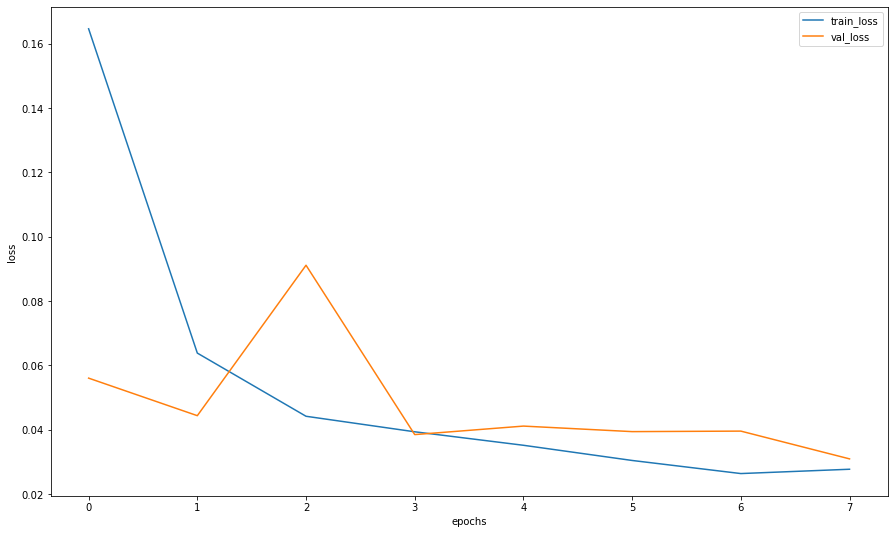

In [40]:
draw_plot(history)

In [17]:
def test(model):
    # Test the model
    model.eval()
    with torch.no_grad():
        accuracy = 0
        for i, (images, labels) in enumerate(loaders['test']):
            print(i)
            images, labels = images.to(device), labels.to(device)
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1]
            accuracy += (pred_y == labels).sum().item() 
        accuracy /= len(loaders['test'].dataset)
        print('Test Accuracy of the model on the 10000 test images: {:.2f} %'.format(accuracy*100.0))

In [47]:
test(hnn)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Test Accuracy of the model on the 10000 test images: 99.11 %


In [54]:
sample = next(iter(loaders['test']))
images, labels = sample
actual_number = labels[:10].numpy()
actual_number

test_output = hnn(images[:10].to(device))
pred_y = torch.max(test_output, 1)[1].cpu().numpy()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [8 4 3 9 4 6 2 4 2 0]
Actual number: [8 4 3 9 4 6 2 4 2 0]


In [53]:
torch.nn.functional.softmax(test_output)

<ipython-input-53-429642a251d7>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(test_output)


tensor([[6.7347e-09, 3.3360e-10, 2.2880e-10, 2.4755e-06, 6.5204e-07, 9.9999e-01,
         1.7102e-06, 2.0303e-09, 1.7067e-07, 5.2945e-06],
        [9.0944e-05, 6.7658e-03, 1.8291e-02, 8.8062e-03, 3.7265e-04, 3.6177e-05,
         1.9353e-05, 9.6331e-01, 1.5673e-03, 7.4037e-04],
        [2.0128e-06, 2.3713e-08, 1.2734e-05, 5.5169e-06, 6.0020e-05, 4.4002e-05,
         3.7533e-07, 1.2752e-06, 1.1731e-06, 9.9987e-01],
        [9.8988e-08, 9.9977e-01, 4.2399e-06, 4.1360e-08, 1.4053e-04, 3.9074e-05,
         5.0901e-06, 3.5419e-05, 3.0632e-06, 3.1663e-06],
        [9.9995e-01, 2.3188e-08, 3.1219e-06, 2.4693e-07, 8.0029e-07, 1.2359e-06,
         1.8518e-05, 1.5103e-06, 1.8404e-06, 2.4621e-05],
        [1.7271e-06, 9.9946e-01, 1.6503e-05, 5.6507e-08, 3.0275e-04, 1.2444e-04,
         1.1543e-05, 6.7242e-05, 3.4002e-06, 8.7738e-06],
        [9.9890e-01, 1.5705e-07, 1.1175e-05, 6.9385e-06, 6.5066e-05, 5.8295e-06,
         5.5960e-05, 1.1560e-06, 5.1467e-06, 9.5117e-04],
        [1.8027e-07, 2.8850